In [1]:
#importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seed=12345
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Documentos/Titulo Propio/Machine Learning/Redes Neuronales/Python/compress.csv' 
df = pd.read_csv(file_path)
#print(df.head())
#La variable de interés es strength, continua
print(f'\n Instancias: {df.shape[0]}; Variables: {df.shape[1]}')


 Instancias: 1030; Variables: 9


In [3]:
#renombramos variables para usarlas más cómodamente
nuevos_nombres = ['cement', 'blast','ash','water','plasticizer','coarse','fine','day','strength']

# Asignar nuevos nombres a las columnas
df.columns = nuevos_nombres

In [4]:
# hay valores perdidos?
df.isna().sum()

cement         0
blast          0
ash            0
water          0
plasticizer    0
coarse         0
fine           0
day            0
strength       0
dtype: int64

Preparamos la base de datos para la aplicación de redes neuronales:

    - Estandarizar/normalizar variables continuas
    - Convertir a dummies las variables categóricas
    - Evitar missing

In [5]:
# organiza las variables según su naturaleza
#hacer una lista con las variables input numericas
num_cols = ['cement', 'blast','ash','water','plasticizer','coarse','fine','day','strength']
#hacer una lista con las variables input categóricas: no hay

In [6]:
#Normalizar variables numericas
#Si se quisieran estandarizar, scaler=StandardScaler()
scaler = MinMaxScaler() #selecciona el transformador
X = df[num_cols] #selecciona las variables numéricas que se quieren transformar y las guarda en un nuevo dataframe
X_scale = pd.DataFrame(scaler.fit_transform(X)) #guarda el resultado de la transformación de las variables de X en X_scale
X_scale.columns = X.columns #para simplificar los nombres, asigna a las columnas de X_scale los nombres de las variables de X_num
df[num_cols] = X_scale
#OJO: incluye el target

In [7]:
# Tuneo y evaluación predictiva del modelo para variable dependiente continua
# El grupo de variables predictoras se define y se fija
X = df[['cement','blast','water']] #en X las variables ya están normalizadas y con dummies
y = df['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
red = MLPRegressor()
#definimos los parámetros que queremos tunear
params = {
    'max_iter': [500],
    'hidden_layer_sizes': [5,7,9],
    'activation': ['tanh','relu'],
    'alpha': [0.001,0.0001]
}
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
# cv = crossvalidation con n folds con todas las combinaciones de parámetros
grid_search = GridSearchCV(estimator=red, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='neg_mean_squared_error')

#ajusta en entrenamiento con todas las combinaciones
grid_search.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=MLPRegressor(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.001, 0.0001],
                         'hidden_layer_sizes': [5, 7, 9], 'max_iter': [500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [9]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)
# Mostrar resultados
print("Resultados de Grid Search:")
print(results[['params','mean_test_neg_mean_absolute_error','mean_test_r2']])
#print(results) #para ver todos los atributos obtenidos y entender cómo usarlos

# Obtener el mejor modelo (en cuanto a optimización del criterio)
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

Resultados de Grid Search:
                                               params  \
0   {'activation': 'tanh', 'alpha': 0.001, 'hidden...   
1   {'activation': 'tanh', 'alpha': 0.001, 'hidden...   
2   {'activation': 'tanh', 'alpha': 0.001, 'hidden...   
3   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...   
4   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...   
5   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...   
6   {'activation': 'relu', 'alpha': 0.001, 'hidden...   
7   {'activation': 'relu', 'alpha': 0.001, 'hidden...   
8   {'activation': 'relu', 'alpha': 0.001, 'hidden...   
9   {'activation': 'relu', 'alpha': 0.0001, 'hidde...   
10  {'activation': 'relu', 'alpha': 0.0001, 'hidde...   
11  {'activation': 'relu', 'alpha': 0.0001, 'hidde...   

    mean_test_neg_mean_absolute_error  mean_test_r2  
0                           -0.163884      0.023758  
1                           -0.144286      0.252871  
2                           -0.153348      0.135804  
3              

- params: Una lista de diccionarios que contiene los valores de los hiperparámetros para cada combinación evaluada.
- mean_test_score: Una matriz que contiene las puntuaciones promedio de prueba para cada combinación de hiperparámetros.
- std_test_score: Una matriz que contiene las desviaciones estándar de las puntuaciones de prueba para cada combinación de hiperparámetros.

Otros detalles como el tiempo de ajuste ('mean_fit_time'), tiempo de puntuación ('mean_score_time'), etc.

- neg_mean_squared_error: Error cuadrático medio negativo. Se utiliza comúnmente en problemas de regresión.
- neg_mean_absolute_error: Error absoluto medio negativo.
- r2: R^2 (Coeficiente de Determinación) mide la proporción de la variabilidad en la variable dependiente que es predecible a partir de las variables independientes.

Algunas métricas como el error cuadrático medio (neg_mean_squared_error) son más efectivas cuando son más bajas, mientras que otras como el coeficiente de determinación (r2) son más efectivas cuando son más altas. Al utilizar el parámetro scoring, ten en cuenta el sentido de la métrica y si deseas maximizarla o minimizarla al especificar greater_is_better

In [29]:
# Escogemos la parametrizaciones mejores candidatas: 4, 8, 10
print("Parametrización 4:")
print(results.iloc[4].params)
print("Parametrización 8:")
print(results.iloc[8].params)
print("Parametrización 10:")
print(results.iloc[10].params)

Parametrización 4:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 7, 'max_iter': 500}
Parametrización 8:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 9, 'max_iter': 500}
Parametrización 10:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 7, 'max_iter': 500}


In [34]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
r2_1 = results[['split0_test_r2', 'split1_test_r2','split2_test_r2', 'split3_test_r2']].iloc[4]
r2_2 = results[['split0_test_r2', 'split1_test_r2','split2_test_r2', 'split3_test_r2']].iloc[8]
r2_3 =results[['split0_test_r2', 'split1_test_r2','split2_test_r2', 'split3_test_r2']].iloc[10]

# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
mse_1 = results[['split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error', 'split3_test_r2']].iloc[4]
mse_2 = results[['split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error', 'split3_test_r2']].iloc[8]
mse_3 = results[['split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error', 'split3_test_r2']].iloc[10]

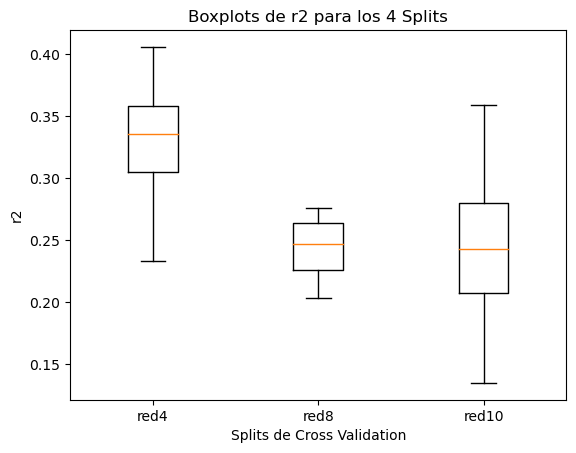

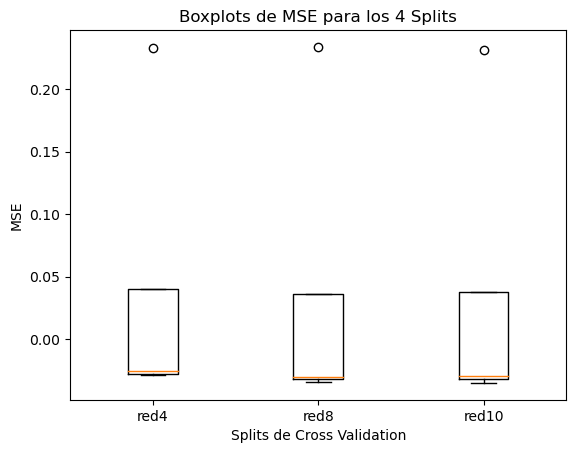

In [35]:
# Crear un boxplot para los cuatro valores de r2
plt.boxplot([r2_1.values,r2_2.values,r2_3.values], labels = ['red4','red8','red10'])
plt.title('Boxplots de r2 para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('r2')
plt.show()

# Crear un boxplot para los cuatro valores de MSE
plt.boxplot([mse_1.values,mse_2.values,mse_3.values], labels = ['red4','red8','red10'])
plt.title('Boxplots de MSE para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('MSE')
plt.show()


# Nótese en la solución que boxplots con gran amplitud no son deseables, ya que se caracterizan por poca robustez de la solución

In [41]:
# Escogemos la red 8 como modelo candidato
red8 = MLPRegressor(**results.iloc[8].params)
# Ajustar el mejor modelo con todo el conjunto de entrenamiento
red8.fit(X_train, y_train)

# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = red8.predict(X_train)
y_test_pred = red8.predict(X_test)

errores = y_train - y_pred_train
# Calcular diferentes medidas de bondad de ajuste
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

# Imprimir las métricas
print(f'MAE (Error Absoluto Medio): {mae:.2f}')
print(f'MSE (Error Cuadrático Medio): {mse:.2f}')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}')
print(f'R²: {r2:.2f}')

MAE (Error Absoluto Medio): 0.17
MSE (Error Cuadrático Medio): 0.05
RMSE (Raíz del Error Cuadrático Medio): 0.21
R²: -0.08
